# Handwritten Equation Decipherment (HED)

This notebook shows an implementation of [Handwritten Equation Decipherment](https://proceedings.neurips.cc/paper_files/paper/2019/file/9c19a2aa1d84e04b0bd4bc888792bd1e-Paper.pdf). As shown below, the handwritten equations consist of sequential pictures of characters. The equations are generated with unknown operation rules from images of symbols ('0', '1', '+' and '='), and each equation is associated with a label indicating whether the equation is correct (i.e., positive) or not (i.e., negative). An agent is required to learn from a training set of such equations and then to predict labels of unseen equations. Note that the operation rules governing the label assignment of labels, "xnor" in this example, are unknown, and the sizes of equations can be different.

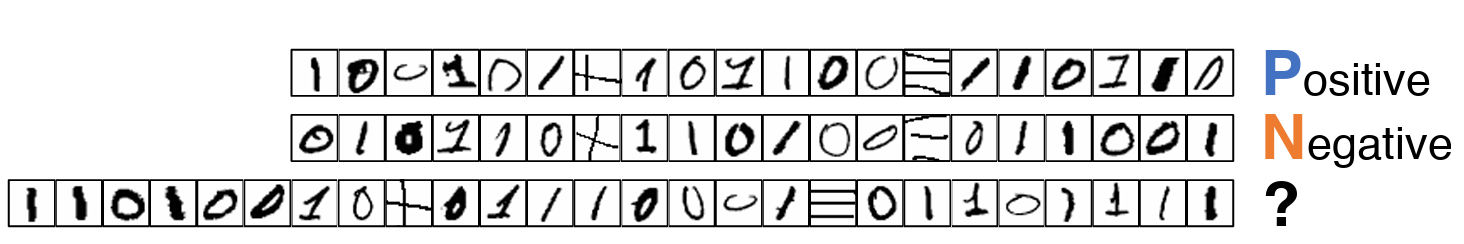

In [1]:
# Import necessary libraries and modules
import os.path as osp
import torch
import torch.nn as nn
from examples.hed.datasets import get_dataset, split_equation
from examples.models.nn import SymbolNet
from abl.learning import ABLModel, BasicNN
from examples.hed.reasoning import HedKB, HedReasoner
from abl.evaluation import ReasoningMetric, SymbolMetric
from abl.utils import ABLLogger, print_log
from examples.hed.bridge import HEDBridge

## Working with Data

In [2]:
total_train_data = get_dataset(train=True)
train_data, val_data = split_equation(total_train_data, 3, 1)
test_data = get_dataset(train=False)

## Building the Learning Part

In [3]:
# Build necessary components for BasicNN
cls = SymbolNet(num_classes=4)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(cls.parameters(), lr=0.001, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Build BasicNN
# The function of BasicNN is to wrap NN models into the form of an sklearn estimator
base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    device,
    batch_size=32,
    num_epochs=1,
    stop_loss=None,
)

In [5]:
model = ABLModel(base_model)

## Building the Reasoning Part

In [6]:
kb = HedKB()
reasoner = HedReasoner(kb, dist_func="hamming", use_zoopt=True, max_revision=10)

## Building Evaluation Metrics

In [7]:
# Set up metrics
metric_list = [SymbolMetric(prefix="hed"), ReasoningMetric(kb=kb, prefix="hed")]

## Bridging Learning and Logic Reasoning

In [8]:
bridge = HEDBridge(model, reasoner, metric_list)

Perform traing and testing.

In [9]:
# Build logger
print_log("Abductive Learning on the HED example.", logger="current")

# Retrieve the directory of the Log file and define the directory for saving the model weights.
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.pretrain("./weights")
bridge.train(train_data, val_data)

12/21 11:23:55 - abl - INFO - Abductive Learning on the HED example.
12/21 11:23:55 - abl - INFO - Loads checkpoint by local backend from path: ./weights/pretrain_weights.pth
12/21 11:23:55 - abl - INFO - ============== equation_len: 5-6 ================
12/21 11:23:55 - abl - INFO - Equation Len(train) [5] Segment Index [1]
[zoopt] x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
[zoopt] value: [0.0, 10.0]
[zoopt] x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
[zoopt] value: [0.0, 10.0]
[zoopt] x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.